In [1]:
import numpy as np
import pandas as pd
import random
import math
import json
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

In [2]:
class Chromosome:
    def __init__(self, genes, length):
        self.genes = genes
        self.length = length
        self.fitness = 0

    def randomGenerateChromosome(self):
        for i in range(0, self.length):
            gen = float('%.2f' % random.uniform(0.0, 1.0))
            self.genes.append(gen)

        return self

    def mutate(self, mutation_rate):
        for i in range(self.length):
            if random.random() < mutation_rate:
                self.genes[i] = float('%.2f' % random.uniform(0.0, 1.0))

In [3]:
class Cluster:
    def __init__(self, centroid):
        self.centroid = centroid
        self.points = []

    def computeS(self):
        n = len(self.points)
        if n == 0:
            return 0
        s = np.sum(np.linalg.norm(self.points - self.centroid, axis=1))
        return s / n

In [4]:

class Clustering:
    def __init__(self, data, kmax):
        self.data = data
        self.kmax = kmax

    def initialize_clusters(self):
        centroids_idx = random.sample(range(len(self.data)), self.kmax)
        centroids = [self.data[i] for i in centroids_idx]
        return [Cluster(centroid) for centroid in centroids]

    def assign_points_to_clusters(self, clusters):
        for point in self.data:
            min_dist = float('inf')
            closest_cluster = None
            for cluster in clusters:
                dist = np.linalg.norm(point - cluster.centroid)
                if dist < min_dist:
                    min_dist = dist
                    closest_cluster = cluster
            closest_cluster.points.append(point)

    def update_cluster_centroids(self, clusters):
        for cluster in clusters:
            if len(cluster.points) > 0:
                cluster.centroid = np.mean(cluster.points, axis=0)

    def euclidean_distance(self, point1, point2):
        return np.linalg.norm(point1 - point2)

    def k_means_objective(self, clusters):
        objective = 0.0
        for cluster in clusters:
            for point in cluster.points:
                objective += self.euclidean_distance(point, cluster.centroid)
        return objective

    def crossover(self, parent1, parent2):
        cut_point = random.randint(1, self.kmax - 1)
        genes1 = parent1.genes[:cut_point] + parent2.genes[cut_point:]
        genes2 = parent2.genes[:cut_point] + parent1.genes[cut_point:]
        child1 = Chromosome(genes1, self.kmax)
        child2 = Chromosome(genes2, self.kmax)
        return child1, child2

    def run_genetic_algorithm(self, num_individuals, max_generations, mutation_rate, crossover_rate):
        population = []
        for _ in range(num_individuals):
            chromosome = Chromosome([], self.kmax)
            chromosome.randomGenerateChromosome()
            population.append(chromosome)

        for generation in range(max_generations):
            for chromosome in population:
                clusters = self.initialize_clusters()
                self.assign_points_to_clusters(clusters)
                self.update_cluster_centroids(clusters)
                chromosome.fitness = self.k_means_objective(clusters)

            population.sort(key=lambda x: x.fitness)
            elite_size = int(0.1 * num_individuals)
            elite = population[:elite_size]

            new_population = elite.copy()

            while len(new_population) < num_individuals:
                parent1 = random.choice(population)
                parent2 = random.choice(population)
                if random.random() < crossover_rate:
                    child1, child2 = self.crossover(parent1, parent2)
                    child1.mutate(mutation_rate)
                    child2.mutate(mutation_rate)
                    new_population.extend([child1, child2])

            population = new_population

        best_chromosome = population[0]
        best_clusters = self.initialize_clusters()
        self.assign_points_to_clusters(best_clusters)
        self.update_cluster_centroids(best_clusters)

        return best_clusters

In [5]:
def minmax_normalize(data):
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    normalized_data = (data - min_vals) / (max_vals - min_vals)
    return normalized_data

Cluster 1 Centroid: [0.19611111 0.595      0.07830508 0.06083333]
Cluster 2 Centroid: [0.43842593 0.29166667 0.5819209  0.55833333]
Cluster 3 Centroid: [0.70486111 0.47083333 0.78220339 0.80416667]


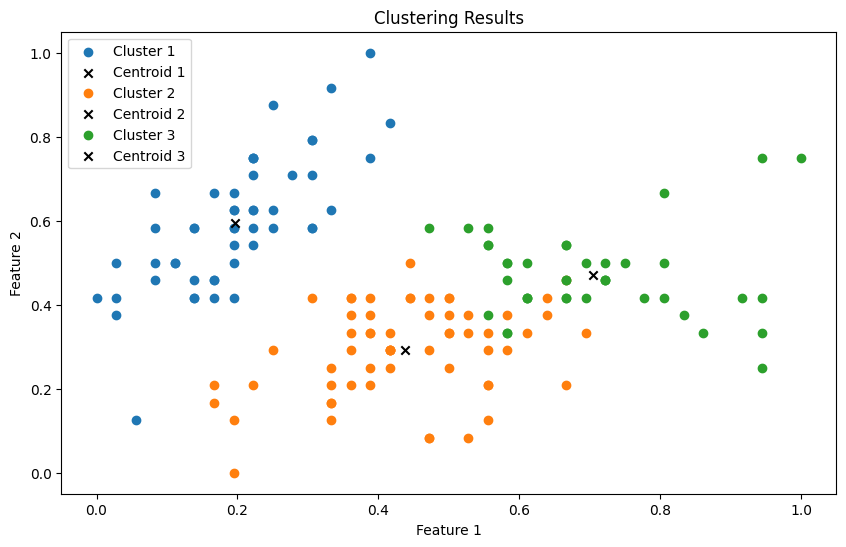

In [6]:
def main():
    iris = load_iris()
    data = iris.data
    data = minmax_normalize(data)

    clustering = Clustering(data, kmax=3)
    best_clusters = clustering.run_genetic_algorithm(
        num_individuals=50, max_generations=100, mutation_rate=0.01, crossover_rate=0.8)

    for i, cluster in enumerate(best_clusters):
        print(f"Cluster {i+1} Centroid: {cluster.centroid}")

    plt.figure(figsize=(10, 6))
    for i, cluster in enumerate(best_clusters):
        points = np.array(cluster.points)
        plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {i + 1}')
        centroid = np.array([cluster.centroid])
        plt.scatter(centroid[:, 0], centroid[:, 1], marker='x', color='black', label=f'Centroid {i + 1}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Clustering Results')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()